In [10]:
import logging
from typing import Any, Dict, Iterator, List, Tuple

import numpy as np
from numpy.typing import NDArray
from scipy.special import sph_harm
import os
os.chdir("/zhome/71/c/146676/material_tensor_tomo")
from mumott.spherical_harmonics import SphericalHarmonics
import mumott.geometry as geometry
import matplotlib.pyplot as plt

In [11]:
import importlib
from scipy.spatial.transform import Rotation as R
importlib.reload(geometry)
geom = geometry.Geometry()
n_azith_bins = 50
n_rot_bins = 1
azith_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)
rot_angles = np.linspace(0,np.pi, n_rot_bins, endpoint=False) # change these to be matrices!!!

geom.detector_angles = azith_angles
geom.two_theta = [0.1,0.2]
geom.full_circle_covered  = True                     # because detector covers 0..2π

# Build (N,3,3) rotations about z
Rz = [R.from_rotvec(np.array([0.,0.,1.]) * a).as_matrix() for a in rot_angles[0:1]]
geom.rotations = Rz
print(type(Rz))
print(Rz)
    


probed_coords = geom._get_probed_coordinates()
print(probed_coords.vector.shape)

<class 'list'>
[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])]
(1, 100, 3, 3)


In [13]:
import mumott.odf_geometry as odf_geometry
importlib.reload(odf_geometry)

<module 'mumott.odf_geometry' from '/zhome/71/c/146676/material_tensor_tomo/mumott/odf_geometry.py'>

In [14]:
n_azith_bins = 60
azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)
ell_max = 2
n_segments = 3
two_theta = np.linspace(1, 2, 1)


og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation=0.0)
probes = og.build_probed_coordinates()
sharm = SphericalHarmonics(ell_max=ell_max, probed_coordinates=probes)
K = len(sharm.ell_indices)
print(K)
print(probes.vector.shape)




9
(1, 60, 3, 3)


[ 0.28209479-0.j  0.29920671-0.j  0.24430126-0.j -0.29920671-0.j
  0.28970565-0.j  0.33452327-0.j -0.07884789-0.j -0.33452327-0.j
  0.28970565-0.j]
(60,)


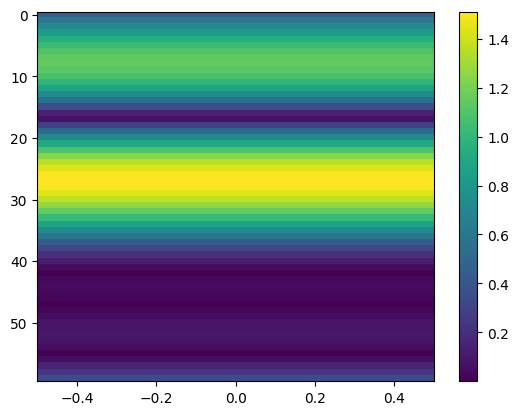

In [15]:
from scipy.special import sph_harm

def delta_sh_coeffs_array(theta0, phi0, ell_max, enforce_friedel=False):
    """
    Return SH coefficient vector for a delta-like ODF.

    Parameters
    ----------
    theta0, phi0 : float
        Orientation angles (polar, azimuth).
    ell_max : int
        Bandlimit.
    enforce_friedel : bool
        If True, only even ell values are used.

    Returns
    -------
    coeffs : np.ndarray, shape (K,)
        Vector of coefficients ordered by (ell,m).
    ell_idx, m_idx : np.ndarray
        The ell and m values corresponding to each coefficient.
    """
    # Build the index arrays
    ell_idx = []
    m_idx   = []
    divisor = 2 if enforce_friedel else 1
    for ell in range(0, ell_max+1, divisor):
        for m in range(-ell, ell+1):
            ell_idx.append(ell)
            m_idx.append(m)
    ell_idx = np.array(ell_idx)
    m_idx   = np.array(m_idx)

    # Compute coefficients
    coeffs = np.conjugate(sph_harm(m_idx, ell_idx, phi0, theta0))
    return coeffs, ell_idx, m_idx

# Example: delta at (theta=pi/3, phi=pi/4), ell_max=4
theta0, phi0 = np.pi/3*1, np.pi/4*0
coeffs, _, _= delta_sh_coeffs_array(theta0, phi0, ell_max=ell_max)

print(coeffs)
B_mat = sharm._get_integrated_projection_matrix()
print((B_mat[0]@coeffs).shape)
plt.imshow(np.abs((B_mat[0]@coeffs)).reshape(len(two_theta),len(azimuthal_angles)).T, aspect='auto')
plt.colorbar()


#### Check the reshaping of Yflat. Someything goes wrong

In [17]:
import cil_addons.odfsh_operator as odfsh_operator
importlib.reload(odfsh_operator)
from cil.framework import ImageGeometry, ImageData, AcquisitionData, AcquisitionGeometry
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.operators import CompositionOperator, BlockOperator



Nx, Ny, Nz = 100,100,2
M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=Nz, center_x=0, center_y=0, center_z=0, channels=M)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=Nz, center_x=0, center_y=0, center_z=0, channels=K)
Nu, Nv = Nx, Nz
px = py = 1.0  # detector pixel size (set to your values)

ag_base = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nu,Nv), pixel_size=(px, py)) \
    .set_angles([0.0]) 
# placeholder; we overwrite per use
ag_base.set_channels(M)
def make_Pr(angle_deg):
    ag = ag_base.copy()
    ag.set_angles([angle_deg])  # 1 angle for this operator
    # Domain is M-channel volume (output of B_r), so operator expects ig_M
    return ProjectionOperator(ig_M, ag)             # set device/backend as needed


rotations = np.linspace(0,180,10)

Br_ops = []
Pr_ops = []

for i in range(len(rotations)):
        og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation = rotations[i])
        Br = odfsh_operator.ODFSHOperator3d(odf_geometry=og, ig_in = ig_K, ig_out=ig_M)
        Pr = make_Pr(rotations[i]*180/np.pi)
        Br_ops.append(Br)
        Pr_ops.append(Pr)

C_rows = [CompositionOperator(Pr_ops[r] , Br_ops[r])  for r in range(len(rotations)) ]   # composition per rotation
# Make a 'tall' BlockOperator with R rows and 1 column
print(*C_rows)
T = BlockOperator(*C_rows, shape=(len(rotations),1))


print(K)
data_in = np.zeros((K,Nz,Ny,Nx), dtype=np.float32)
data_in[0,:,:,:] = 1
data_in[:,0,0,0] = np.real(coeffs)
print(data_in.dtype)
data_in = ImageData(data_in, geometry=ig_K)


data_out = T.direct(data_in)
data_in2= T.adjoint(data_out)

<cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ee4d0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a922f6450> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0edc50> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0eef10> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ef150> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ed0d0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ef210> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ef250> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ef290> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a8a0ef190>
9
float32


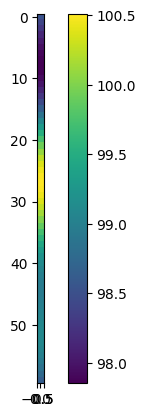

In [18]:
arrs = [block.as_array().reshape((M_two_theta, M_az, Nu, Nv)) for block in data_out]
arrs = np.stack(arrs)
arrs = arrs.transpose((2,1,0,3,4))
plt.imshow(arrs[:,:,0,0,0])
plt.colorbar()


In [19]:
from cil.framework import ImageGeometry, ImageData, AcquisitionData, AcquisitionGeometry
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.operators import CompositionOperator, BlockOperator



Nx, Ny = 400,400
M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, center_x=0, center_y=0, channels=M)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, center_x=0, center_y=0, channels=K)
Nu = Nx
px = 1.0  # detector pixel size (set to your values)

ag_base = AcquisitionGeometry.create_Parallel2D() \
    .set_panel(num_pixels=(Nu), pixel_size=(px)) \
    .set_angles([0.0])
# placeholder; we overwrite per use
ag_base.set_channels(M)
def make_Pr(angle_deg):
    ag = ag_base.copy()
    ag.set_angles([angle_deg])  # 1 angle for this operator
    # Domain is M-channel volume (output of B_r), so operator expects ig_M
    return ProjectionOperator(ig_M, ag)             # set device/backend as needed


rotations = np.linspace(0,180,10)

Br_ops = []
Pr_ops = []

for i in range(len(rotations)):
        og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation = rotations[i])
        Br = odfsh_operator.ODFSHOperator2d(odf_geometry=og, ig_in = ig_K, ig_out=ig_M)
        Pr = make_Pr(rotations[i]*180/np.pi)
        Br_ops.append(Br)
        Pr_ops.append(Pr)

C_rows = [CompositionOperator(Pr_ops[r] , Br_ops[r])  for r in range(len(rotations)) ]   # composition per rotation
# Make a 'tall' BlockOperator with R rows and 1 column
print(*C_rows)
T = BlockOperator(*C_rows, shape=(len(rotations),1))


print(K)
data_in = np.zeros((K,Ny,Nx), dtype=np.float32)
data_in[0,:,:] = 1
data_in[:,0,0] = np.real(coeffs)
print(data_in.dtype)
data_in = ImageData(data_in, geometry=ig_K)


data_out = T.direct(data_in)
data_in2= T.adjoint(data_out)

<cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df1fd0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df1ed0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3bd0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3d10> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3d50> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df2850> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3e10> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3e50> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3e90> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89df3d90>
9
float32


In [20]:
print(data_out[1].as_array().shape)
print(len(data_out))

(60, 400)
10


In [21]:
from cil.framework import ImageGeometry, ImageData, AcquisitionData, AcquisitionGeometry
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.operators import CompositionOperator, BlockOperator

n_azith_bins = 180
azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)

Nx, Ny = 100,100
M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=M, center_x=0, center_y=0, center_z=0)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=K, center_x=0, center_y=0, center_z=0)
Nu, Nv = Nx, M 
px, py = 1.0, 1.0  # detector pixel size (set to your values)

ag_base = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nu, Nv), pixel_size=(px, py)) \
    .set_angles([0.0])
# placeholder; we overwrite per use
def make_Pr(angle_deg):
    ag = ag_base.copy()
    ag.set_angles([angle_deg])  # 1 angle for this operator
    # Domain is M-channel volume (output of B_r), so operator expects ig_M
    return ProjectionOperator(ig_M, ag)             # set device/backend as needed


rotations = np.linspace(0,180,128)

Br_ops = []
Pr_ops = []

for i in range(len(rotations)):
        og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation = rotations[i])
        Br = odfsh_operator.ODFSHOperator2d_fast(odf_geometry=og, ig_in = ig_K, ig_out=ig_M)
        Pr = make_Pr(rotations[i]*180/np.pi)
        Br_ops.append(Br)
        Pr_ops.append(Pr)

C_rows = [CompositionOperator(Pr_ops[r] , Br_ops[r])  for r in range(len(rotations)) ]   # composition per rotation
# Make a 'tall' BlockOperator with R rows and 1 column
print(*C_rows)
T = BlockOperator(*C_rows, shape=(len(rotations),1))


print(K)
data_in = np.zeros((K,Nx,Ny), dtype=np.float32)
data_in[0,:,:] = 1
data_in[:,0,0] = np.real(coeffs)
print(data_in.dtype)
data_in = ImageData(data_in, geometry=ig_K)


data_out = T.direct(data_in)
data_in2= T.adjoint(data_out)



<cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a88499990> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a89d93bd0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fb210> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fb790> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883f9050> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fc750> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fc650> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fc610> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fc590> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fa150> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fc550> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7f0a883fc910> <cil

In [22]:
from cil.optimisation.algorithms import CGLS, SIRT

# Suppose you have built your operator
# op = ODFSHOperator3d(odf_geometry=og, ig_in=ig_K, ig_out=ig_M)

# Create ground truth x_true in domain geometry
data_in = np.zeros((K,Nx,Ny), dtype=np.float32)
data_in[0,20:-20,20:-20] = 1
data_in[0,40:-40,40:-40] = 2
data_in[1,40:-20,40:-40] = 3
data_in[3,20:-40,40:-40] = 0.4
data_in[5,30:-50,30:-50] = 2
data_in = ImageData(data_in, geometry=ig_K)
#data_in = ig_K.allocate()
#data_in.fill(np.random.randn(*ig_K.shape))

# Generate synthetic data
data_out = T.direct(data_in)

# ---- CGLS ----
cgls = CGLS(initial=ig_K.allocate(0), operator=T, data=data_out, max_iteration=100)
cgls.run(25)

x_cgls = cgls.solution
print("CGLS solution norm:", x_cgls.norm())

# ---- SIRT ----
sirt = SIRT(initial=ig_K.allocate(0), operator=T, data=data_out, max_iteration=20)
sirt.run(3)

x_sirt = sirt.solution
print("SIRT solution norm:", x_sirt.norm())


/zhome/71/c/146676/miniconda3/envs/cil/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:01<00:00,  4.86s/it, objective=1.07e+5]


CGLS solution norm: 114.95997


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.27s/it, objective=inf]

SIRT solution norm: inf


(9, 100, 100)


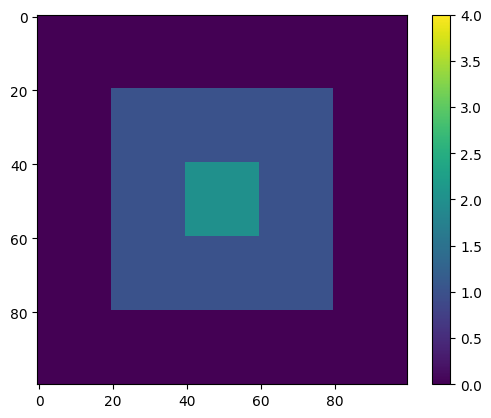

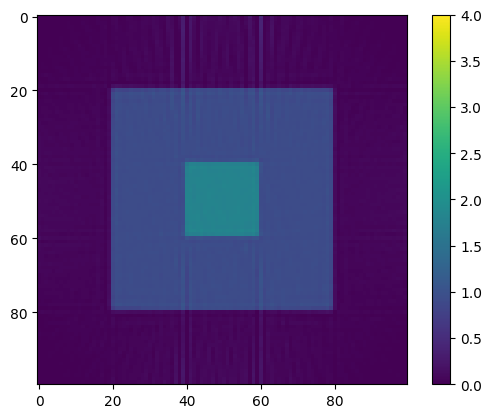

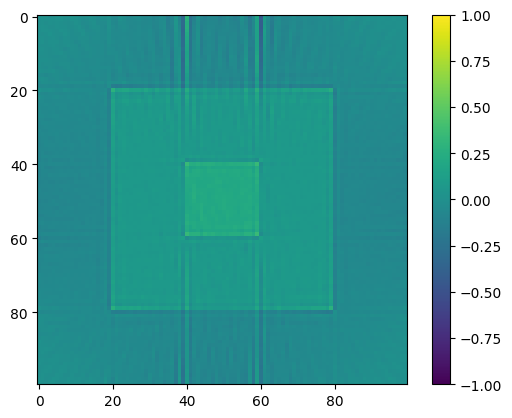

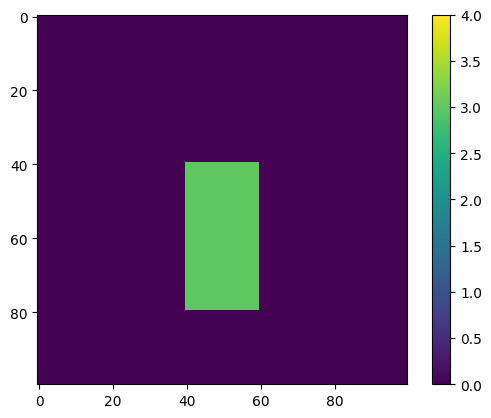

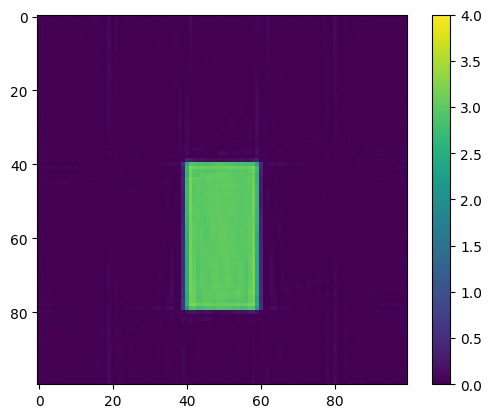

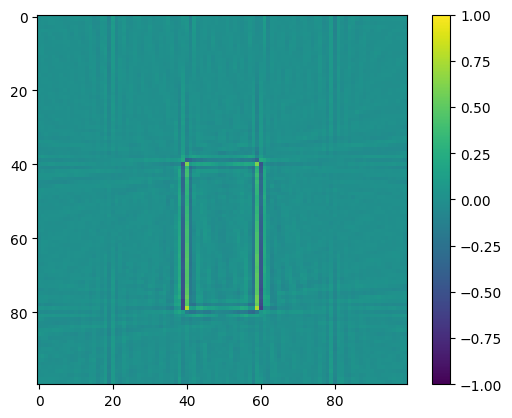

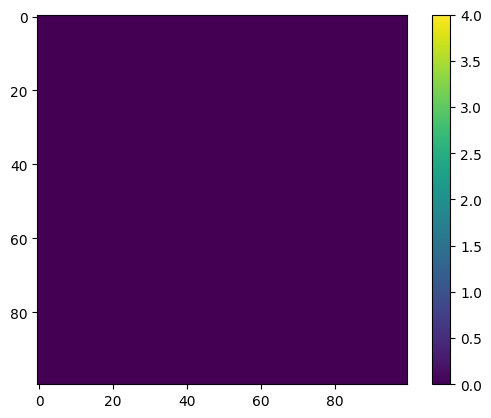

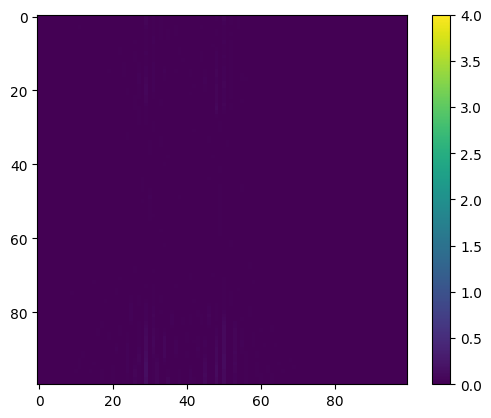

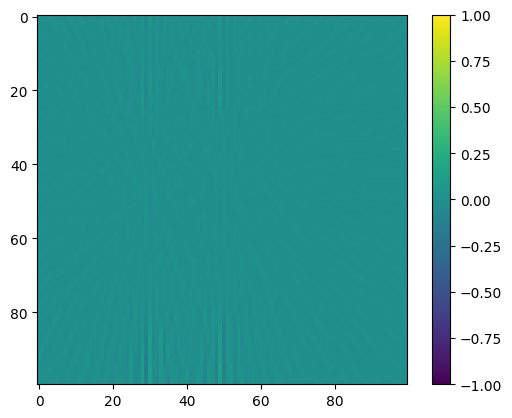

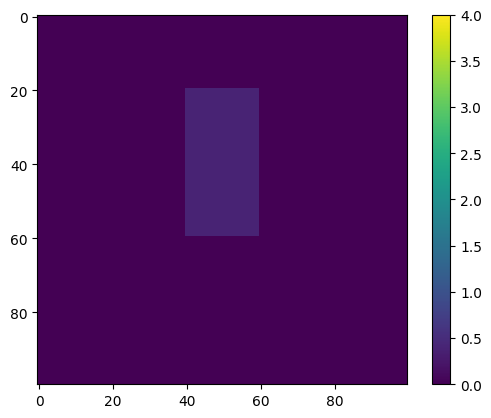

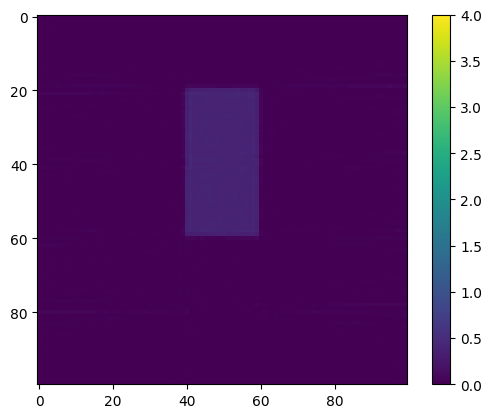

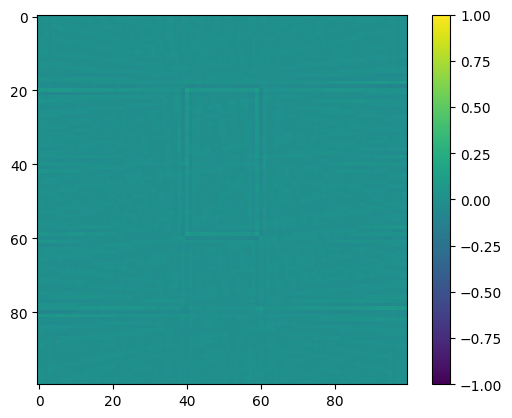

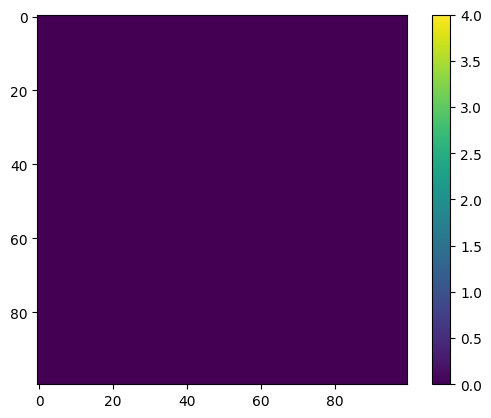

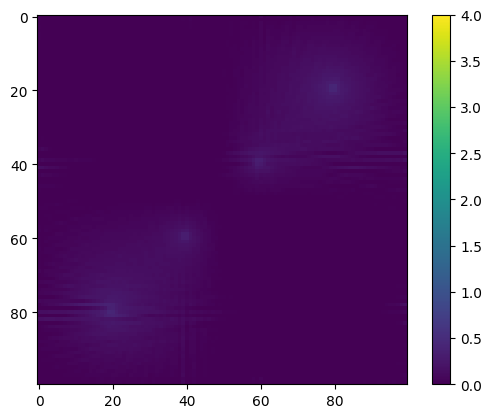

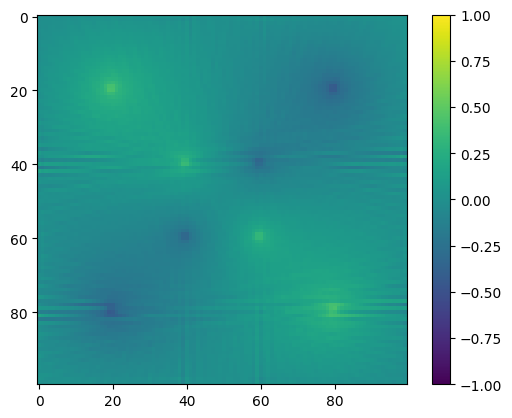

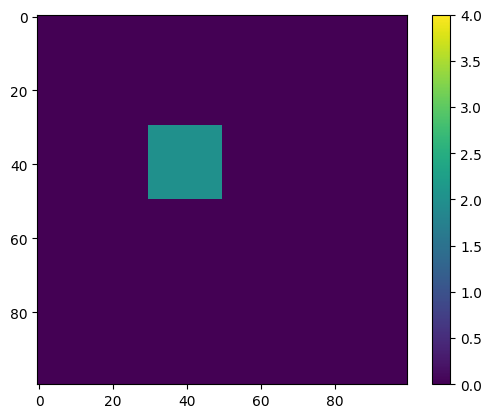

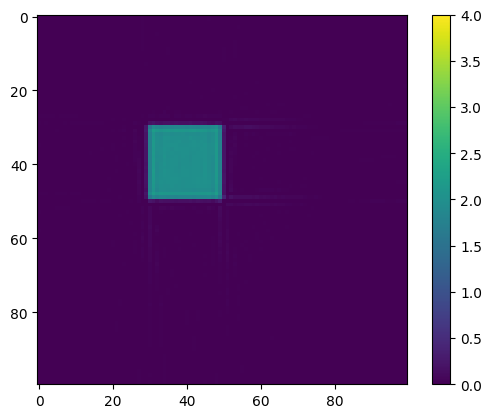

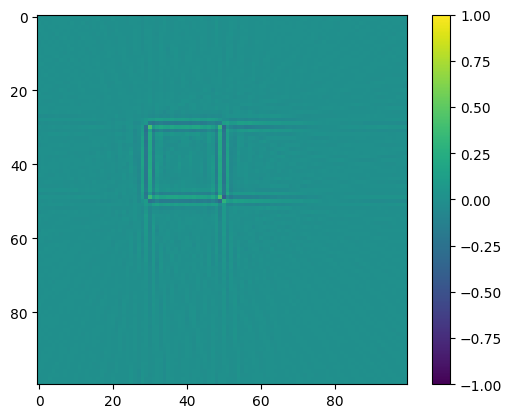

In [23]:
print(x_cgls.as_array().shape)
for i in range(6):
    plt.imshow(data_in.as_array()[i])
    plt.clim([0,4])
    plt.colorbar()
    plt.show()
    plt.imshow(x_cgls.as_array()[i])
    plt.clim([0,4])
    plt.colorbar()
    plt.show()
    plt.imshow(data_in.as_array()[i]-x_cgls.as_array()[i])
    plt.clim([-1,1])
    plt.colorbar()
    plt.show()

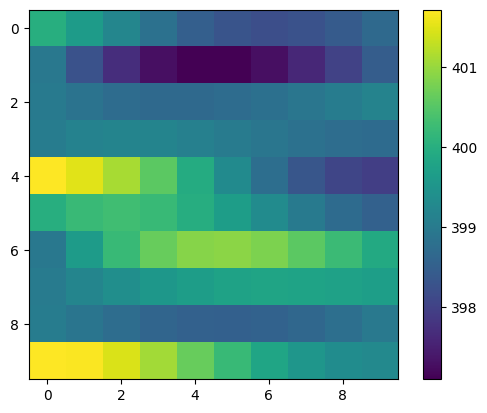

In [13]:
arrs = [block.as_array().reshape((M_two_theta, M_az, Nx)) for block in data_out]
arrs = np.stack(arrs)
arrs = arrs.transpose((2,1,0,3))
plt.imshow(arrs[:,:,0,0])
plt.colorbar()


In [14]:

TTT = 5
import time
t1 = time.time()
for i in range(TTT):
    data__ = Br.direct(data_in)

t2 = time.time()
print('time:', (t2-t1)/TTT)

t1 = time.time()
for i in range(TTT):
    data_o = Pr.direct(data__)

t2 = time.time()
print('time:', (t2-t1)/TTT)


time: 0.10264701843261718
time: 0.046119070053100585


In [49]:
Br_c = Br.direct(data_in)
print('c shape', data_in.as_array().shape)
print('Br c shape', Br_c.as_array().shape)
PBr_c = Pr.direct(Br_c)

c shape (15, 2, 400, 400)
Br c shape (100, 2, 400, 400)


In [50]:

B = odfsh_operator.ODFSHOperator3d(odf_geometry=og, ig_in = ig_in, ig_out=ig_out)
print(K)
data_in = np.zeros((K,2,2,2))
data_in[0,:,:,:] = 1
data_in[:,0,0,0] = coeffs
data_in = ImageData(data_in, geometry=ig_in)




data_out = B.direct(data_in)



NameError: name 'ig_in' is not defined

In [ ]:
C_rows = [ Ar_ops[r] @ Br_ops[r]  for r in range(R) ]   # composition per rotation
# Make a 'tall' BlockOperator with R rows and 1 column
T = BlockOperator(*C_rows, shape=(R,1))
# T.direct(c) returns a BlockDataContainer [y_1, ..., y_R]

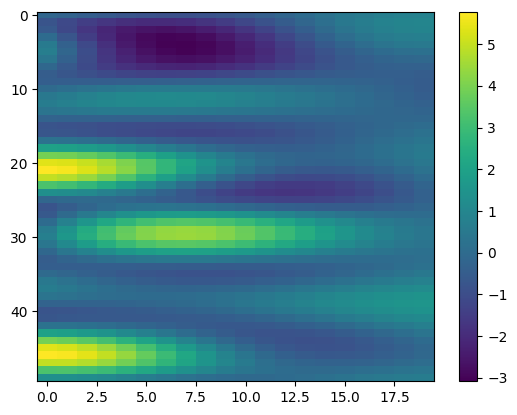

In [ ]:
plt.imshow(data_out.as_array()[:,0,0,0].reshape((len(two_theta),len(azimuthal_angles))).T, aspect='auto')
plt.colorbar()


array([2.7994658 , 3.04641466, 3.30070212, 3.55830496, 3.81514867,
       4.06717177, 4.31038991, 4.54095873, 4.75523454, 4.9498318 ,
       5.12167653, 5.26805483, 5.38665568, 5.47560738, 5.53350713,
       5.55944308, 5.55300876, 5.51430946, 5.44396053, 5.34307772,
       5.21325948, 5.0565618 , 4.87546568, 4.67283802, 4.45188633,
       4.21610812, 3.96923567, 3.71517714, 3.45795484, 3.20164179,
       2.95029737, 2.70790325, 2.47830054, 2.26512911, 2.07177016,
       1.90129276, 1.75640543, 1.6394133 , 1.55218171, 1.49610669,
       1.47209289, 1.48053917, 1.52133234, 1.59384874, 1.6969641 ,
       1.82907114, 1.98810485, 2.17157499, 2.37660532, 2.59997883,
       2.83818846, 3.08749232, 3.34397267, 3.60359763, 3.86228471,
       4.11596516, 4.36064808, 4.59248334, 4.80782225, 5.00327506,
       5.17576443, 5.3225739 , 5.44139076, 5.53034247, 5.5880262 ,
       5.61353098, 5.60645202, 5.56689716, 5.49548514, 5.39333589,
       5.26205287, 5.10369784, 4.92075835, 4.71610857, 4.49296

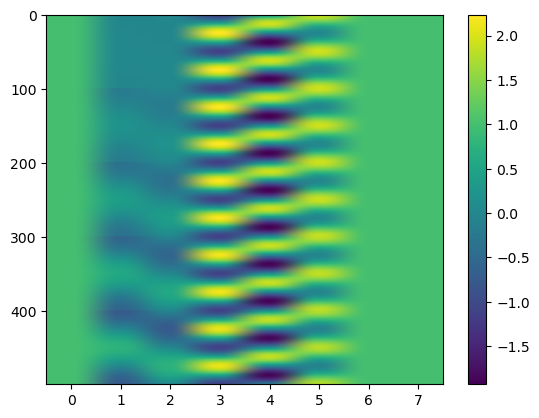

In [ ]:
N, M, K = sharm.projection_matrix.shape  # (projections, detector_segments, coeffs)
plt.imshow(sharm.projection_matrix[0], aspect='auto')
plt.colorbar()
sharm.projection_matrix[0]@np.array([0,1,1,1,1,1,1,1])

In [ ]:
data_out.as_array().shape
print(data_out.as_array()[:,0,0,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
print(sharm.ell_indices.shape)
print(sharm.emm_indices.shape)
print(sharm.projection_matrix.shape)
# 2) Forward for ONE projection (e.g., s=0)
N, M, K = sharm.projection_matrix.shape  # (projections, detector_segments, coeffs)
rng = np.random.default_rng(0)
c = rng.standard_normal((N, K))          # shape (N, K)
print(c.shape)
#Bc = sharm.forward(c)
#print(Bc.shape)


: 

: 

: 